
<div >
<img src="logo.jpg", width=150, ALIGN="left", border=20>
<h1>Sample Starting Kit </h1>
    <span style="color:red"> <h1> Keep all code below **yellow** text blocks, </h1> </span>
    <span style="color:red"> <h1> but check that it works (you can ADD not remove). </h1> </span>
    <span style="color:red"> <h1> Customize Section (1) and modify the explanations.</h1> </span>

<br>This code was tested with <br>
Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.</div>


<div >
    <h2>Introduction </h2>
    <p>
     <br>
This dataset is a small set of patients which have been diagnotised on different stages of cancer. The goal of this challenge is to find two matrices A*T which are the Matrix Factorization of the original data, and to measure the utility of producted A by giving a classification scoring to it.
 <br>
</div>

In [6]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div >
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
</div>

In [7]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
#data_dir = '../FILES/iris/'          # The sample_data directory should contain only a very small subset of the data
data_name = 'hadaca'
#!ls $data_dir*
!dir $data_dir*                     # For Windows users

hadaca_feat.name    hadaca_test.data	  hadaca_train.solution
hadaca_label.name   hadaca_test.solution  hadaca_valid.data
hadaca_public.info  hadaca_train.data	  hadaca_valid.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [8]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)       # The data are loaded as a Pandas Data Frame
# because we have a huge number of features wo only chose some for visualization
data_slice = data.loc[:,data.columns.str.contains('^methyl_0$|^methyl_1$|^methyl_2$|^methyl_3$|^target$')]

Reading sample_data/hadaca_train from AutoML format
Number of examples = 50
Number of features = 1000
          Class
0      stage ib
1      stage ia
2       stage i
3     stage iib
4      stage iv
5    stage iiia
6  not reported
7     stage iia
8           Nan
9    stage iiib
Number of classes = 10


In [11]:
data_slice.head(10)

,methyl_0,methyl_1,methyl_2,methyl_3,target
0.702318,0.724066,0.696525,0.434269,0.142745,stage ib
0.062884,0.691114,0.732033,0.467048,0.079799,stage ib
0.169687,0.584910,0.776171,0.222362,0.125337,stage ib
0.141969,0.627048,0.591641,0.482781,0.429931,stage ib
0.244063,0.462871,0.574462,0.227411,0.381443,stage ib
0.062069,0.444808,0.659272,0.291072,0.266001,stage ia
0.311717,0.738548,0.559514,0.134937,0.644442,stage ia
0.092961,0.258086,0.178107,0.145360,0.052934,stage ia
0.027111,0.449327,0.283592,0.692875,0.512748,stage ia
0.082123,0.398125,0.171400,0.281765,0.084959,stage ia


In [10]:
set(list(data_slice.target))

{'Nan',
 'not reported',
 'stage i',
 'stage ia',
 'stage ib',
 'stage iia',
 'stage iib',
 'stage iiia',
 'stage iiib',
 'stage iv'}

In [12]:
data_slice.describe() 

,methyl_0,methyl_1,methyl_2,methyl_3
count,50.000000,50.000000,50.000000,50.000000
mean,0.484346,0.460418,0.320911,0.241738
std,0.161264,0.186088,0.177818,0.204766
min,0.071852,0.125243,0.022986,0.025921
25%,0.395971,0.293103,0.170468,0.085854
50%,0.477111,0.506020,0.293823,0.120955
75%,0.598308,0.604508,0.478848,0.410706
max,0.738548,0.776171,0.692875,0.760473


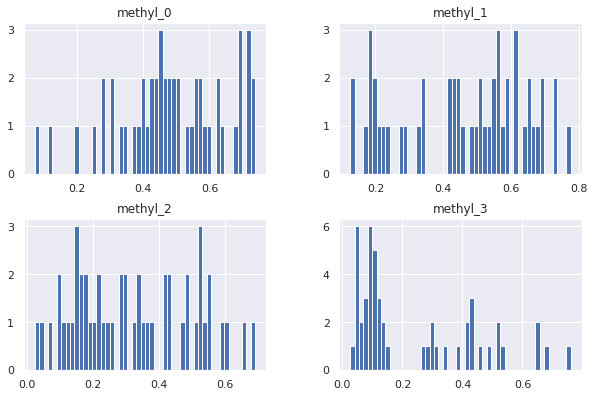

In [13]:
data_slice.hist(figsize=(10, 10), bins=50, layout=(3, 2));

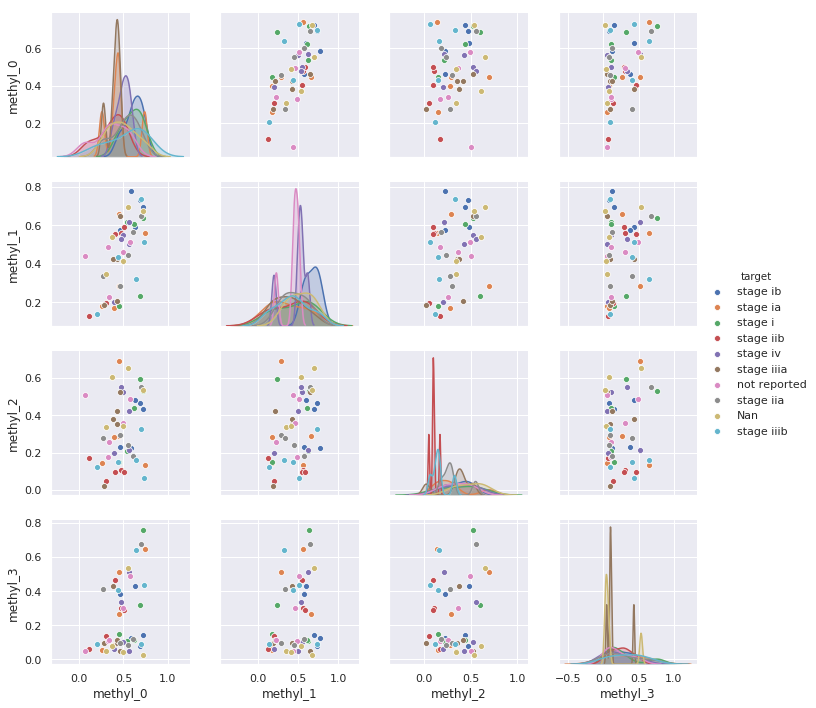

In [14]:
sns.pairplot(data_slice, hue="target")

<div>
<h1>Step 2: Building a predictive model</h1>
</div>

<div >
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     
</div>

In [15]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/didou/myProjects/M2 AIC/project/HADACA/starting_kit/sample_data/hadaca_public.info
DataManager : hadaca
info:
	usage = Sample dataset hadaca
	name = hadaca
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 1000
	target_num = 10
	label_num = 10
	train_num = 50
	valid_num = 50
	test_num = 50
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(50, 1000)
	Y_train = array(50, 1)
	X_valid = array(50, 1000)
	Y_valid = array(50, 1)
	X_test = array(50, 1000)
	Y_test = array(50, 1)
feat_type:	array(1000,)
feat_idx:	array(0,)



<div >
    <h2>Training a predictive model : Without factorisation</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [16]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
??model 

<div >
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [17]:
M = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [18]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [50, 1000]
FIT: dim(y)= [50, 1]
PREDICT: dim(X)= [50, 1000]
PREDICT: dim(y)= [50, 1]
PREDICT: dim(X)= [50, 1000]
PREDICT: dim(y)= [50, 1]
PREDICT: dim(X)= [50, 1000]
PREDICT: dim(y)= [50, 1]


/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<div >
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [19]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
#!ls $result_name*

<div >
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [20]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: accuracy_score


<div >
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [21]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the accuracy_score metric = 0.9200
Ideal score for the accuracy_score metric = 1.0000


You can add here other scores and result visualization.

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 4]])

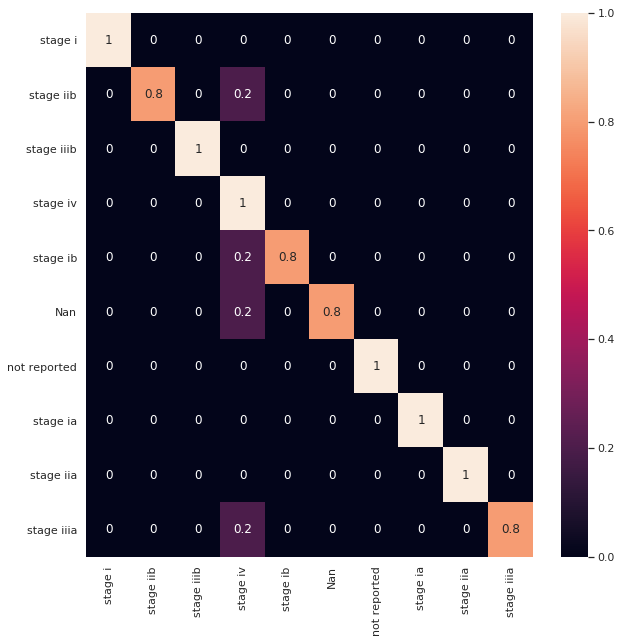

In [23]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred1 = Y_hat_train
y_test1 = Y_train
array = confusion_matrix(y_test1, y_pred1)
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]


df_cm = pd.DataFrame(array, index = set(list(data_slice.target)) , columns = set(list(data_slice.target)))
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.show()

<div >
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [24]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [40, 1000]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 1000]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 1000]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 1000]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 1000]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 1000]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 1000]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 1000]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 1000]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 1000]
PREDICT: dim(y)= [10, 1]

CV score (95 perc. CI): 0.00 (+/- 0.00)


/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

## Training a predictive model :  With factorisation

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import  mean_squared_error

svd = TruncatedSVD(n_components = 100)
A_train = svd.fit_transform(X_train)
#A_test = svd.fit_transform(X_test)

T = svd.components_
print(A_train.shape)
print(T.shape)
D = np.dot(A_train,T)
print(D.shape)
################ WARNING ###############
# pearson = np.corrcoef(D,X_art)
# print("Pearson =", pearson) 
########################################

rmse = mean_squared_error(D,X_train)
print("RMSE =", rmse)


(50, 50)
(50, 1000)
(50, 1000)
RMSE = 9.053122675062871e-30


In [26]:
M1 = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)           

In [27]:

if not(M1.is_trained):
    X_train_facto = svd.fit_transform(D.data['X_train'])
    Y_train = D.data['Y_train']
    M1.fit(X_train_facto, Y_train)       
    
Y_hat_train_facto = M1.predict(svd.fit_transform(D.data['X_train'])) # Optional, not really needed to test on taining examples
Y_hat_valid_facto = M1.predict(svd.fit_transform(D.data['X_valid']))
Y_hat_test_facto = M1.predict(svd.fit_transform(D.data['X_test']))

TypeError: memoryview: invalid slice key

In [39]:
M1.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train_facto)
write(result_name + '_valid.predict', Y_hat_valid_facto)
write(result_name + '_test.predict', Y_hat_test_facto)
#!ls $result_name*

In [38]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: accuracy_score


In [40]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train_facto))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the accuracy_score metric = 1.0000
Ideal score for the accuracy_score metric = 1.0000


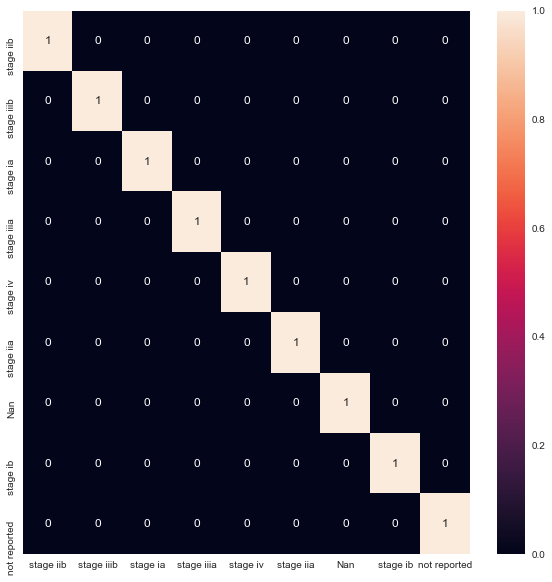

In [41]:
y_pred1 = Y_hat_train_facto
y_test1 = Y_train
array = confusion_matrix(y_test1, y_pred1)
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]


df_cm = pd.DataFrame(array, index = set(list(data_slice.target)) , columns = set(list(data_slice.target)))
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.show()

In [42]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train_facto, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [40, 50]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 50]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 50]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 50]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 50]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 50]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 50]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 50]
PREDICT: dim(y)= [10, 1]
FIT: dim(X)= [40, 50]
FIT: dim(y)= [40, 1]
PREDICT: dim(X)= [10, 50]
PREDICT: dim(y)= [10, 1]

CV score (95 perc. CI): 0.28 (+/- 0.23)


<div >
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div >
Also test the scoring program:
    </div>

In [79]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

/usr/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
======= Set 1 (Hadaca_test): accuracy_score(set1_score)=0.340000000000 =======
======= Set 2 (Hadaca_train): accuracy_score(set2_score)=0.280000000000 =======
======= Set 3 (Hadaca_valid): accuracy_score(set3_score)=0.300000000000 =======


<div >
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [80]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip'
sample_result_submission = 'sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
sample_code_submission_18-11-21-19-59.zip
sample_result_submission_18-11-21-19-59.zip
